In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
def measureRandomAccess(size,filename='',k=100000):
    """ Measure the distribution of random accesses in computer memory.
    size=size of memory block.
    filename= a file that is used as an external buffer. If filename=='' then everything is done in memory.
    k = number of times that the experiment is repeated.
    output:
    mean = the mean of T
    std = the std of T
    T = a list the contains the times of all k experiments
    """
    # Prepare buffer.
    if filename == '':
        inmem=True
        A=bytearray(size)
    else:
        inmem=False
        file=open(filename,'r+')
        
    # Read and write k times from/to buffer.
    sum=0; sum2=0
    T=np.zeros(k)
    for i in range(k):
        if (i%10000==0): print i,',',
        t=time.time()
        loc=int(rand()*size)
        if inmem:
            x=A[loc:loc+4]
            A[loc]=(i % 256)
        else:
            file.seek(loc)
            poke=file.read(1)
            file.write("test")
        d=time.time()-t
        T[i]=d
        sum += d
        sum2 += d*d
    mean=sum/k; var=(sum2/k)-mean**2; std=sqrt(var)
    return (mean,std,T)

In [3]:
from matplotlib.backends.backend_pdf import PdfPages
from scipy.special import erf,erfinv

def PlotTime(Tsorted,Mean,Std,Color='b',LS='-',Legend=''):
    """ plot distribution of times on a log-log scale"""
    P=arange(1,0,-1.0/k)    # probability 
    loglog(Tsorted,P,color=Color,label=Legend,linestyle=LS)                 # plot log-log of 1-CDF 
    
    grid()
    loglog([Mean,Mean],[1,0.0001],color=Color,linestyle=LS)           # vert line at mean
    Y=0.1**((m_i+1.)/2.)
    loglog([Mean,min(Mean+Std,1)],[Y,Y],color=Color,linestyle=LS) # horiz line from mean to mean + std
        
    x=arange(Mean,Mean+Std*erfinv(1.0-1.0/len(Tsorted)),Std/100)  # normal distribution 
    loglog(x,1-erf((x-Mean)/Std),color=Color,linestyle=LS)

In [4]:
n=1000000 # size of single block (1MB)
m_list=[1,10,100,1000] #,10000] # size of file in blocks
m=None
k=100000;
L=len(m_list)
#print 'n=%d, m=%d,k=%d, m_list=' % (n,m,k),m_list

from os.path import isfile,isdir
from os import mkdir
import os
root=os.environ['HOME']
log_root=root+'/logs'
if not isdir(log_root): mkdir(log_root)
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print line
    stat.write(line+'\n')

/home/sadat/logs/1445018355


In [5]:
!ls -lh

total 0
-rw-rw-r-- 1 sadat sadat 0 Oct 16 10:59 stats.txt


0 , 
creating 1000000 byte block: 0.000219 sec, writing 1 blocks 0.000518 sec
0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000 , 70000 , 80000 , 90000 , 
File pokes mean=1.83408260345e-06, file std=1.44516840494e-06
0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000 , 70000 , 80000 , 90000 , 
Memory pokes mean=5.1052570343e-07, file std=6.01377219704e-07
0 , 
creating 1000000 byte block: 0.000088 sec, writing 10 blocks 0.003205 sec
0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000 , 70000 , 80000 , 90000 , 
File pokes mean=1.98671340942e-06, file std=8.20583650776e-07
0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000 , 70000 , 80000 , 90000 , 
Memory pokes mean=5.93597888947e-07, file std=6.15239802919e-07
0 , 
creating 1000000 byte block: 0.000040 sec, writing 100 blocks 0.029785 sec
0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000 , 70000 , 80000 , 90000 , 
File pokes mean=2.22387075424e-06, file std=1.21758327724e-06
0 , 10000 , 20000 , 30000 , 40000 , 50000 , 60000 , 70000 , 80000

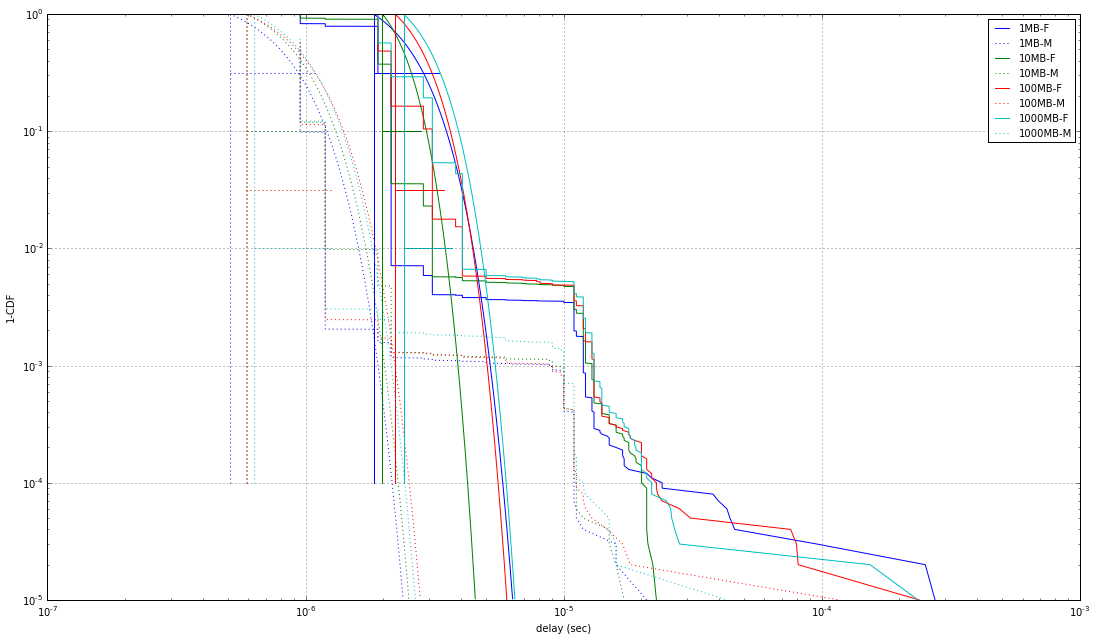

In [6]:
def create_file(n,m,filename='DataBlock'):
    t1=time.time()
    A=bytearray(n)
    t2=time.time()
    file=open(filename,'w')
    for i in range(m):
        file.write(A)
        if i % 100 == 0:
            print i,",",
    file.close()
    t3=time.time()
    tee('\ncreating %d byte block: %f sec, writing %d blocks %f sec' % (n,t2-t1,m,t3-t2))
    return (t2-t1,t3-t2)

mean=zeros([2,L])   #0: using disk, 1: using memory
std=zeros([2,L])
T=zeros([2,L,k])

for m_i in range(len(m_list)):
    
    m=m_list[m_i]
    (t_mem,t_disk) = create_file(n,m,filename='BlockData'+str(m))

    (mean[0,m_i],std[0,m_i],T[0,m_i]) = measureRandomAccess(n*m,filename='BlockData'+str(m),k=k)
    tee('\nFile pokes mean='+str(mean[0,m_i])+', file std='+str(std[0,m_i]))

    (mean[1,m_i],std[1,m_i],T[1,m_i]) = measureRandomAccess(n*m,k=k)
    tee('\nMemory pokes mean='+str(mean[1,m_i])+', file std='+str(std[1,m_i]))

pp = PdfPages('MemoryFigure.pdf')
figure(figsize=(6,4))

Colors='bgrcmyk'  # The colors for the plot
LineStyles=['-',':']
Legends=['F','M']

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)

for m_i in range(len(m_list)):
    Color=Colors[m_i % len(Colors)]
    for Type in [0,1]:
        PlotTime(sort(T[Type,m_i]),mean[Type,m_i],std[Type,m_i],
                 Color=Color,LS=LineStyles[Type],Legend=('%dMB-' % m_list[m_i])+Legends[Type])

grid()
legend(fontsize='medium')
xlabel('delay (sec)')
ylabel('1-CDF')
pp.savefig()
pp.close()

In [ ]:
import time

Line='Consecutive Memory writes'
print Line; stat.write(Line+'\n')
n=1000
r=np.array(range(n))
for m in [1,3,5,7,10,100,1000,10000,100000,1000000]:
    t1=time.time()
    A=np.repeat(r,m)
    t2=time.time()
    tee("array of length %d repeated %d times. total size=%6.3f MB, Time per element= %g" % (n,m,float(n*m)/1000000,(t2-t1)/float(n*m)))
A=[];r=[]
stat.close()

## Main Observations

* If you write to consecutive locations, you have a per-byte time of around $10^{-8}$ if you jump around you can't do better than $10^{-6}$.
* As you increase the size of the array/file random access speed decreases dramatically, while sequential access speed stays more or less constant.
* The high latency tails are much bigger than what you'd expect from a normal distribution with the same mean and std.

#### Impact on Big Data Analytics
* Clock rate is stuck at around 3GHz, and is likely to be stuck there for the forseeable future.
* **Faster** computers / disks / networks are **expensive** 
* The cost-effective solution is often a cluster of many cheap computers, each with many cores and break up the data so that each computer has a small fraction of the data.
* Data-Centers and the "Cloud"